Script to make a Venn diagram of number of genes in each condition.

Input files are downsampled

data files needed to run are available at SCP: https://singlecell.broadinstitute.org/single_cell/study/SCP979/
please download:<br>
visium_A1_stdata.tsv <br>
visium_B1_stdata.tsv <br>
visium_D1_stdata.tsv <br>
visium_A1_annotations.txt <br>
visium_B1_annotations.txt <br>
visium_D1_annotations.txt <br>
10015CN108_C1_stdata.tsv <br>
10015CN108fl_E2_stdata.tsv <br>
5005CN107_D2_stdata.tsv <br>
10015CN108_C1_annotations.txt <br>
10015CN108fl_E2_annotations.txt <br>
5005CN107_D2_annotations.txt <br>

In [3]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from matplotlib_venn import venn2

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [158]:
# Make a sample-condition dictionary
sam_cond = {'Visium': ['visium_A1', 'visium_B1', 'visium_D1'],
           'sm-omics':['10015CN108_C1', '10015CN108fl_E2', '5005CN107_D2']}


In [418]:
# Load input files, tsv files from st-pipeline

path = '../../smomics_data'

samples_list = ['visium_A1', 'visium_B1', 'visium_D1', '10015CN108_C1', '10015CN108fl_E2', '5005CN107_D2']
 
files_dict = {}
    
for filename in samples_list:
    
    file = pd.read_csv(os.path.join(path, filename + '_stdata.tsv'), sep = '\t', index_col=0)

    files_dict[filename] = file.T


In [444]:
'Splits counts file to inside vs outside tissue'
genes_under_tissue_dict = {}
    
for filename in samples_list:
    
    file = pd.read_csv(os.path.join(path, filename + '_annotations.txt'), sep = '\t', index_col=0)
    spot_coordTMP = list()
    
    file = file[file['value'] != 'Unknown']
 
    # 10015CN108fl_E2 samples have spot coordinates in float...
    if filename == '10015CN108fl_E2':
        for spots in file['x_y'].tolist():
            spot_tmp = [ float(elem) for elem in spots.split('_') ]
            spot_tmp2 = [ round(elem, 0) for elem in spot_tmp ]
            spot_tmp3 = [ int(elem) for elem in spot_tmp2 ]

            new_spot_coord = str(spot_tmp3[0]) + 'x' + str(spot_tmp3[1])
            spot_coordTMP.append(new_spot_coord)
    else:
        for spots in file['x_y'].tolist():
            spots_tmp = spots.split('_')
            new_spot_coord = str(spots_tmp[0]) + 'x' + str(spots_tmp[1])   
            spot_coordTMP.append(new_spot_coord)
        
    # Remove spots on border, ie ending in x35 or x1 for Sm-
    spot_coord = []
    for spot in spot_coordTMP[:]:
        if spot.split('x')[1] != '35':
            if (not "visium" in filename):
                spot_coord.append(spot)
            else:
                spot_coord.append(spot)
        if spot.split('x')[0] != '1':
            if (not "visium" in filename):
                spot_coord.append(spot)
            else:
                spot_coord.append(spot)
    if filename == '5005CN107_D2':
        spot_coord.remove('5x5')
        spot_coord.remove('5x5')
    if filename == '10015CN108_C1':
        spot_coord.remove('14x35')
        spot_coord.remove('10x35')
        spot_coord.remove('13x35')
        spot_coord.remove('11x35')
        spot_coord.remove('12x35')
    # Only store those samples I am interested in
    if filename in samples_list:
        genes_under_tissue_dict[filename] = spot_coord

files_underoutside_tissue_dict = {}

for k, v in files_dict.items():
    #print(genes_under_tissue_dict[k])
    v_under_tissue = v[genes_under_tissue_dict[k]]
    v_under_tissue = v_under_tissue.loc[:,~v_under_tissue.columns.duplicated()]
    
    # Spots outside of tissue
    spots_outside_tissue = [x for x in list(v) if x not in list(v_under_tissue)]
    v_outside_tissue = v[spots_outside_tissue] 
    v_outside_tissue = v_outside_tissue.loc[:,~v_outside_tissue.columns.duplicated()]
    files_underoutside_tissue_dict[k] = [v_under_tissue, v_outside_tissue]

In [445]:
# Filter on sequencing depth
seq_depth = {'10015CN108_C1':[50786142, 50.7],
            '10015CN108fl_E2':[85685215, 85.6],
            '5005CN107_D2':[53954136, 53.9],
             'visium_A1':[64384261, (4993/1007)*64.4],
              'visium_B1':[73848603, (4993/1007)*73.9],
              'visium_D1':[78790129, (4993/1007)*78.8]}
co = 800
gene_dict = {}
for key, value in files_underoutside_tissue_dict.items():
    
    for i, val in enumerate(value): # [inside/outside] of tissue  
        
        # Sum the counts for each gene
        val['tot count'] = val.sum(axis=1)

        # Remove genes (rows) where the total sum is less than xx       
        value_red = val[val['tot count'] > seq_depth[key][1]]

        # Remove tot count column
        value_red.drop(['tot count'], axis = 1, inplace=True)
        
        # remove lowly expressed spots
        value_red = value_red.loc[:, value_red.sum(axis=0) > co]
        
        # remove lowest 5% genes
        value_red = value_red.loc[value_red.astype(bool).sum(axis = 1) > 10,:]
        
        if (i == 0) & (len(value_red.columns) > 0): # inside tissue
            # Store these gene name
            genes = value_red.index.tolist()    
            gene_dict[key] = genes
            print(key)
            print(len(genes))

visium_A1
6599
visium_B1
8499
visium_D1
8202
10015CN108_C1
4406
10015CN108fl_E2
3662
5005CN107_D2
7679


In [446]:
# Take the average of the 3 replicates
ave_genes_dict = {}

for key, value in sam_cond.items():
    
    genes_in_common = list()
    
    for gene_key, gene_value in gene_dict.items():
        
        print(len(gene_value))
        
        if gene_key in value:
            
            genes_in_common.append(gene_value)

    # Which genes are present in all three samples? 
    ave_genes = list(set(genes_in_common[0]).intersection(genes_in_common[1],genes_in_common[2]))
    
    ave_genes_dict[key] = ave_genes


6599
8499
8202
4406
3662
7679
6599
8499
8202
4406
3662
7679


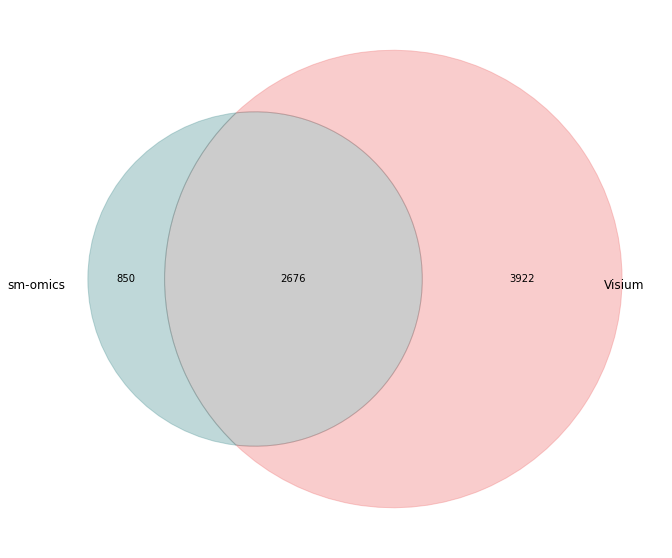

In [447]:
# Plot figure with subplots of different sizes
fig = plt.figure(figsize=(10, 5)) 
ax1 = plt.subplot2grid((1, 1), (0, 0))

a = venn2([set(ave_genes_dict['sm-omics']), set(ave_genes_dict['Visium'])], set_labels = ('sm-omics', 'Visium'), ax=ax1)

#ax1.text(-0.8, 0.5,'A', fontsize=22)

lbl = a.get_label_by_id('A')
x, y = lbl.get_position()
lbl.set_position((-0.65, 0))  
lbl = a.get_label_by_id('B')
x, y = lbl.get_position()
lbl.set_position((0.6, 0))

a.get_patch_by_id('10').set_color('cadetblue')
a.get_patch_by_id('01').set_color('lightcoral')
a.get_patch_by_id('11').set_color('grey')

fig.set_size_inches(20, 10)
# plt.savefig("../../figures/SM_ST_Venn.pdf", transparent=True, bbox_inches = 'tight',
#    pad_inches = 0, dpi=1200)

In [448]:
len(set(ave_genes_dict['sm-omics']))/len(set(ave_genes_dict['Visium']))

0.5344043649590785

In [405]:
"Translate ensembl gene symbols to refseq"
genes_names_dict = pd.read_csv("../../smomics_data/Gene_names_mm.txt", header = None)
genes_names_dict['ensemble'] = list([i.split("_")[0] for i in genes_names_dict[0]])
genes_names_dict['names'] = list([i.split("_")[1] for i in genes_names_dict[0]])
genes_names_dict = genes_names_dict.drop(0, axis = 1)
genes_names_dict.index = genes_names_dict['ensemble']
genes_names_dict = genes_names_dict.drop('ensemble', axis = 1)
genes_names_dict_final = genes_names_dict.to_dict()

In [360]:
"Get sm-omics gene names"
smomics_genes =  [genes_names_dict_final['names'][key] for key in ave_genes_dict['sm-omics']]

In [361]:
"Get st gene names"
visium_genes =  [genes_names_dict_final['names'][key] for key in ave_genes_dict['Visium']]

In [363]:
"Check if genes in sm-omics and st"
for gene in 'Sytl2', 'Myl4', 'Tnnc1', 'Igfbp6', 'Baalc', 'Satb2', 'Asap1', 'Hkdc1', 'Fhod3', 'Stard8', 'Exph5', 'Ier5', 'Trib1', 'Mybpc1', 'Bend5', 'Lmna', 'Abcb6', 'Gtdc1', 'Dact2', 'D8Ertd82e', 'Pamr1', 'Cckbr', 'LOC381765', 'Kcnh7', 'LOC433228', 'E130012A19Rik', '1110008P14Rik', 'Mef2c', 'Spag5', 'Prss12', 'Crhr1', 'Ighm', 'Ddit4l', 'Tshz3', 'Gm12429', 'Pak7', '1700019N12Rik', 'Fezf2', 'LOC381557', 'Dkk3':
    if gene in smomics_genes:
        print(gene, " gene in SM-Omics")
    if not gene in visium_genes:
        print(gene, " gene not in Visium")

Sytl2  gene in SM-Omics
Satb2  gene in SM-Omics
Asap1  gene in SM-Omics
Hkdc1  gene not in Visium
Fhod3  gene in SM-Omics
Stard8  gene not in Visium
Exph5  gene not in Visium
Ier5  gene in SM-Omics
Mybpc1  gene not in Visium
Bend5  gene not in Visium
Abcb6  gene not in Visium
Gtdc1  gene in SM-Omics
LOC381765  gene not in Visium
Kcnh7  gene in SM-Omics
LOC433228  gene not in Visium
E130012A19Rik  gene in SM-Omics
Mef2c  gene in SM-Omics
Spag5  gene not in Visium
Prss12  gene not in Visium
Ddit4l  gene in SM-Omics
Tshz3  gene in SM-Omics
Gm12429  gene not in Visium
Pak7  gene in SM-Omics
1700019N12Rik  gene not in Visium
LOC381557  gene not in Visium
Dkk3  gene in SM-Omics
